<a id='home'></a>

# Modelo de crédito para pessoa física

## Conteúdo

- [Análise exploratória dos dados](#explora)
- [Pré-processamento, limpeza, e remoção de dados](#dataprep)
- [Modelos de classificação](#modelo)
  - [k-nearest neighbors](#zipcode)
  - [Bernoulli naive bayes](#texto)
  - [Gaussian naive bayes](#numer)
  - [Árvore de decisão](#categ)
  - [Stacking de modelos](#stack)
- [Avaliação da solução](#avalia)
- [Importância das variáveis](#importance)

<a id='explora'></a>

## Análise exploratória dos dados

[topo](#home)

In [1]:
%matplotlib inline

import sys

sys.path.append('../python')

from modelos import clf_bnb
from modelos import clf_dtc
from modelos import clf_gnb
from modelos import clf_knn

from myutils import amostragem, dataprep
from myplots import plot_roc

from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataset = pd.read_csv('../dados/dataset.csv') \
    .drop_duplicates()

dataset.head(3)

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,NaN,10000.0,NaN,NaN,NaN,NaN,0,...,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.0,23936.0,Muriaé,MG,NaN,1.0,0,...,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.0,2600.0,18000.0,5000.0,Araxá,MG,10000.0,0.0,0,...,0.0,1.0,0.0,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN


In [3]:
pre_aprovados = dataset.pre_approved.value_counts()

print('Solicitações pré-aprovadas:', pre_aprovados[1])

Solicitações pré-aprovadas: 14998


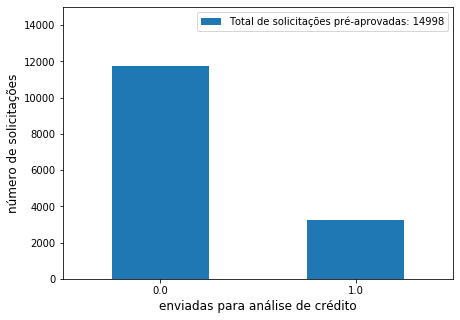

In [4]:
enviadas = dataset[dataset.pre_approved==1.0]['sent_to_analysis'].value_counts()

label = f'Total de solicitações pré-aprovadas: {pre_aprovados[1]}' 

enviadas.plot.bar(rot=0, figsize=(7, 5), label=label)

plt.ylabel('número de solicitações', fontsize='large')
plt.xlabel('enviadas para análise de crédito', fontsize='large')
plt.ylim(0, 15e3)
plt.legend();

In [5]:
print('Solicitações pré-aprovadas e enviadas para análise de crédito:', enviadas[1])

Solicitações pré-aprovadas e enviadas para análise de crédito: 3269


<a id='dataprep'></a>

## Pré-processamento, limpeza, e remoção de dados

[topo](#home)

In [6]:
publico = dataprep(dataset)

In [7]:
print(f'   {"coluna":>25} {"tipo":>10} {"unicos":>10} {"nulos":>10}')
      
for i, col in enumerate(publico.columns):
    col_dtype = str(publico[col].dtype)
    col_count = publico[col].nunique()
    col_nulos = publico[col].isna().sum()
    print(f'{i+1:>2} {col:>25} {col_dtype:>10} {col_count:>10} {col_nulos:>10}')

                      coluna       tipo     unicos      nulos
 1                        id      int64      13290          0
 2                       age    float64         56          0
 3            monthly_income    float64       1303          0
 4               loan_amount    float64        926          0
 5                      city     object       2098          1
 6                     state     object         27          0
 7         dishonored_checks      int64          2          0
 8             banking_debts      int64          2          0
 9          commercial_debts      int64          2          0
10                  protests      int64          2          0
11      informed_restriction      int64          3          0
12           monthly_payment    float64       2162          0
13          informed_purpose     object       8091          0
14                auto_brand     object         49          0
15                auto_model      int64       1552          0
16      

<a id='modelo'></a>

## Modelos de classificação

[topo](#home)

In [8]:
""" Amostras de treino, teste e validação
"""

target = 'sent_to_analysis'

df_train, df_teste, df_valid = amostragem(publico, target)

print('train:', df_train.shape)
print('teste:', df_teste.shape)
print('valid:', df_valid.shape)

train: (7974, 25)
teste: (2658, 25)
valid: (2658, 25)


In [9]:
y_train = df_train[target]
y_teste = df_teste[target]
y_valid = df_valid[target]

X_train = df_train.drop(target, axis=1)
X_teste = df_teste.drop(target, axis=1)
X_valid = df_valid.drop(target, axis=1)

<a id='zipcode'></a>

### K-nearest neighbors

[topo](#home)

In [10]:
%%time

knn = clf_knn(X_train, y_train)

X_teste_knn = X_teste.zip_code.values.reshape(-1, 1)
X_valid_knn = X_valid.zip_code.values.reshape(-1, 1)

knn_score_teste = knn.predict_proba(X_teste_knn)[:, 1]
knn_score_valid = knn.predict_proba(X_valid_knn)[:, 1]

CPU times: user 1.05 s, sys: 2.34 ms, total: 1.05 s
Wall time: 1.05 s


<a id='texto'></a>

### Bernoulli Naive bayes

[topo](#home)

In [11]:
%%time

bnb = clf_bnb(X_train, y_train)

X_teste_bnb = X_teste.informed_purpose
X_valid_bnb = X_valid.informed_purpose

bnb_score_teste = bnb.predict_proba(X_teste_bnb)[:, 1]
bnb_score_valid = bnb.predict_proba(X_valid_bnb)[:, 1]

CPU times: user 80.8 ms, sys: 49 µs, total: 80.9 ms
Wall time: 79 ms


<a id='numer'></a>

### Gaussian naive bayes

[topo](#home)

In [12]:
%%time

gnb = clf_gnb(X_train, y_train)

X_teste_gnb = X_teste.select_dtypes(include=['float64'])
X_valid_gnb = X_valid.select_dtypes(include=['float64'])

gnb_score_teste = gnb.predict_proba(X_teste_gnb)[:, 1]
gnb_score_valid = gnb.predict_proba(X_valid_gnb)[:, 1]

CPU times: user 19.6 ms, sys: 2.87 ms, total: 22.4 ms
Wall time: 21.2 ms


<a id='categ'></a>

### Árvore de decisão

[topo](#home)

In [13]:
%time

dtc = clf_dtc(X_train, y_train)

X_teste_dtc = X_teste.select_dtypes(include=['int64'])
X_valid_dtc = X_valid.select_dtypes(include=['int64'])

dtc_score_teste = dtc.predict_proba(X_teste_dtc)[:, 1]
dtc_score_valid = dtc.predict_proba(X_valid_dtc)[:, 1]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


<a id='stack'></a>

### Stacking de modelos

[topo](#home)

In [14]:
X_teste_stack = np.c_[dtc_score_teste, bnb_score_teste, gnb_score_teste, knn_score_teste]
X_valid_stack = np.c_[dtc_score_valid, bnb_score_valid, gnb_score_valid, knn_score_valid]

In [15]:
F, _ = f_classif(X_teste_stack, y_teste)

f_scores = pd.DataFrame(
    data = F/F.max(),
    index = ['dtc', 'bnb', 'gnb', 'knn'],
    columns = ['f']
)

best_f_scores = f_scores.sort_values(by='f', ascending=False)
best_f_scores

,f
dtc,1.000000
bnb,0.224850
gnb,0.124645
knn,0.033704


In [16]:
reg = LogisticRegression(random_state=42, solver='lbfgs')

auc_scores = []

for i in range(1, 5):
    reg.fit(X_teste_stack[:, :i], y_teste)
    reg_score = reg.predict_proba(X_valid_stack[:, :i])[:, 1]
    reg_auc = roc_auc_score(y_valid, reg_score)
    auc_scores.append(reg_auc)
    
reg_score_valid = reg_score

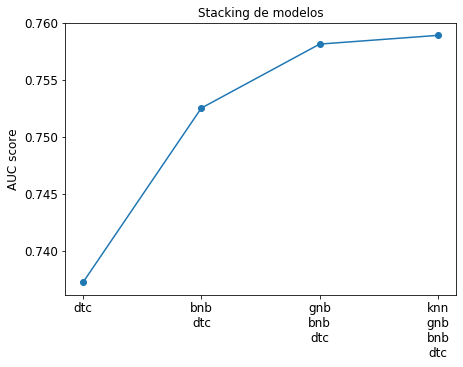

In [17]:
plt.subplots(figsize=(7, 5))

modelos = [
    'dtc',
    'bnb\ndtc',
    'gnb\nbnb\ndtc',
    'knn\ngnb\nbnb\ndtc'
]

plt.plot(modelos, auc_scores, 'o-')
plt.tick_params(labelsize='large')
plt.title('Stacking de modelos', fontsize='large')
plt.ylabel('AUC score', fontsize='large');

<a id='avalia'></a>

## Avaliação da solução

[topo](#home)

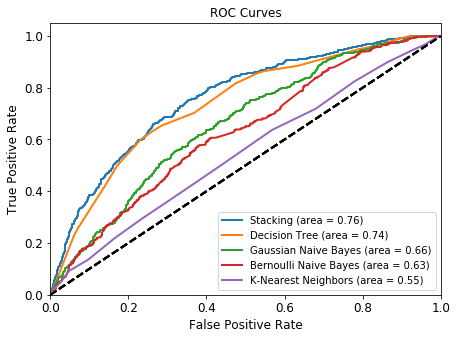

In [18]:
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)
                  
plot_roc(y_valid, reg_score_valid, label='Stacking', ax=ax)
plot_roc(y_valid, dtc_score_valid, label='Decision Tree', ax=ax)
plot_roc(y_valid, gnb_score_valid, label='Gaussian Naive Bayes', ax=ax)
plot_roc(y_valid, bnb_score_valid, label='Bernoulli Naive Bayes', ax=ax)
plot_roc(y_valid, knn_score_valid, label='K-Nearest Neighbors', ax=ax);

<a id='importance'></a>

## Importância das variáveis

[topo](#home)

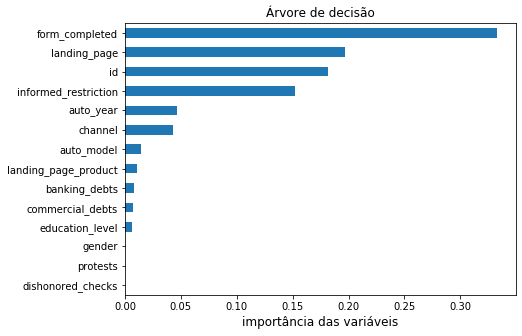

In [19]:
dtc_columns = X_train.select_dtypes(include=['int64']).columns

df = pd.DataFrame(
    data=dtc.feature_importances_,
    index=dtc_columns
).sort_values(by=0)

df.plot.barh(figsize=(7, 5))

plt.title('Árvore de decisão', fontsize='large')
plt.xlabel('importância das variáveis', fontsize='large')
plt.legend().remove()